# <u>Chapter 3: Introduction to your Kepler science lightcurve</u>

<div class="alert alert-block alert-info">

### This Notebook will give you the tools to:

- open Kepler science lighcurves
- understand data structure in fits files
- understand basic features of data
- start with fitting your dataset

### What you should achieve:

- plot and inspect data
- identify transits
- make a plan for modelling

### What's next:
after you have completed this notebook:

- perform detailed modelling of your data
- write up the summary of your modelling
- collect your results for the comparison with other datasets
    
### Table of contents:
    
- [1. Reading Kepler data](#sec:keplerdata)
- [2. Step by step guide to your data](#sec:dataguide)
- [Summary](#sec:summary)

<div class="alert alert-block alert-warning">
    
<b>Make sure to edit the box below to match your assigned object number.</b>

In [1]:
#Necessary imports
from astropy.io import fits #used to open fits files in which data are stored
import matplotlib.pyplot as plt #plotting
import glob
import numpy as np
#add here the source number assigned to you, '1' (Team Osiris) or '2' (Team Dagon)
#Check Moodle to see which object has been assigned to you
mykepler = '1' 

<a id="sec:keplerdata"></a>
## 1. Reading Kepler data

First, we will have a look at the dataset, we have given you the fits dataset exactly as provided by Kepler, you can download additional datasets [on the Kepler archive](https://archive.stsci.edu/kepler/). We have though made the header anonymous so you cannot see which source you are working with. 

In [2]:
#Fits files are open like this:
lc = fits.open('Data/Object%slc/kplr%s_1.fits'%(mykepler, mykepler))

Fits files are common in astrophysics, they have different extensions, which can be images or tables. The information discribing the data is stored in the header.

In [3]:
lc

[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7f0bf8456820>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7f0bceca3a00>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7f0bceca3c40>]

In [4]:
#The header for the first extension can be accesses like this:
lc[0].header
#It contains basic information about the object (some of those removed here)

SIMPLE  =                    T / conforms to FITS standards                     
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T / file contains extensions                       
NEXTEND =                    2 / number of standard extensions                  
EXTNAME = 'PRIMARY '           / name of extension                              
EXTVER  =                    1 / extension version number (not format version)  
ORIGIN  = 'NASA/Ames'          / institution responsible for creating this file 
DATE    = '2015-09-09'         / file creation date.                            
CREATOR = '826630 FluxExporter2PipelineModule' / pipeline job and program used t
PROCVER = 'svn+ssh://murzim/repo/soc/tags/release/9.3.22 r60269' / SW version   
FILEVER = '6.1     '           / file format version                            
TIMVERSN= 'OGIP/93-003'     

**You will see some of the header keywords to read 'None of your business', this is because we have anonymized the dataset for you. 

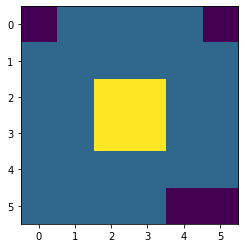

In [5]:
#The last extension holds a small image of the source:
plt.imshow(lc[2].data)

In [6]:
#It also has a header that gives more information
lc[2].header

XTENSION= 'IMAGE   '           / marks the beginning of a new HDU               
BITPIX  =                   32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                    6 / length of first array dimension                
NAXIS2  =                    6 / length of second array dimension               
PCOUNT  =                    0 / group parameter count (not used)               
GCOUNT  =                    1 / group count (not used)                         
INHERIT =                    T / inherit the primary header                     
EXTNAME = 'APERTURE'           / name of extension                              
EXTVER  =                    1 / extension version number (not format version)  
TELESCOP= 'Kepler  '           / telescope                                      
INSTRUME= 'Kepler Photometer'  / detector type                                  
OBJECT  = 'None of your busi

In [7]:
#lets have a look at the second extension
lc[1]
#This is a table extension

In [8]:
#Here the beginning has a description of columns in the table, including the units
lc[1].header

XTENSION= 'BINTABLE'           / marks the beginning of a new HDU               
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  100 / length of first array dimension                
NAXIS2  =                 4370 / length of second array dimension               
PCOUNT  =                    0 / group parameter count (not used)               
GCOUNT  =                    1 / group count (not used)                         
TFIELDS =                   20 / number of table fields                         
TTYPE1  = 'TIME    '           / column title: data time stamps                 
TFORM1  = 'D       '           / column format: 64-bit floating point           
TUNIT1  = 'BJD - 2454833'      / column units: barycenter corrected JD          
TDISP1  = 'D14.7   '           / column display format                          
TTYPE2  = 'TIMECORR'        

This is our lightcirve extension. You will notice two lighcurves here. "SAP_FLUX" is the Simple Aperture Photometry, whereas "PDCSAP_FLUX" is Pre-search Data Condictioned, i.e. has had processing applied for calibration. 

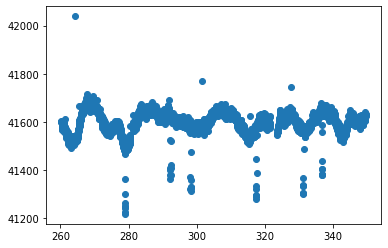

In [9]:
#Lets plot the lightcurve, you can plot the time and flux:
plt.plot(lc[1].data['TIME'], lc[1].data['PDCSAP_FLUX'], ls='None', marker='o')
#This plots the barycentre time and flux in e/s

<ErrorbarContainer object of 3 artists>

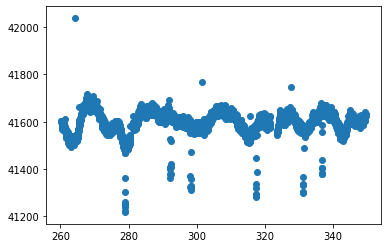

In [10]:
#Measurements errors are also included, you can plot them as follows
plt.errorbar(lc[1].data['TIME'], lc[1].data['PDCSAP_FLUX'], lc[1].data['PDCSAP_FLUX_ERR'], ls='None', marker='o')
#We'll need to zoom in to see them:

<a id="sec:dataguide"></a>
## 2. Step by step guide to your data

#### Do not panic (or maybe do), what you have seen so far is only a small subset of the data you will be working with.

<div class="alert alert-block alert-success">
    
### Your turn: First look at data - signal-to-noise

- calculate the signal to noise of your lightcurve. Compare it to the signal-to-noise you required to detect a trsnait in Chapter 1. You can also compare it to some of the aperture photometry in Chapter 2.

In [11]:
sn = np.nanmean(lc[1].data['PDCSAP_FLUX']/lc[1].data['PDCSAP_FLUX_ERR'])
print (sn)

5684.182


In [12]:
sn_alt= np.nanmedian(lc[1].data['PDCSAP_FLUX']/lc[1].data['PDCSAP_FLUX_ERR'])
print(sn)

5684.182


<div class="alert alert-block alert-success">
    
### Your turn: First look at data - What does your lightcurve look like?

Make notes about your lightcurve: you will be fitting this for planets, do you see any complications?

(260.0, 350.0)

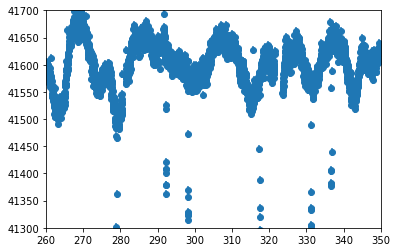

In [13]:
plt.errorbar(lc[1].data['TIME'], lc[1].data['PDCSAP_FLUX'], lc[1].data['PDCSAP_FLUX_ERR'], ls='None', marker='o')
plt.ylim(41300,41700)
plt.xlim(260,350)

(260.0, 350.0)

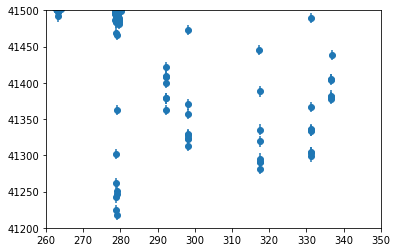

In [14]:
plt.errorbar(lc[1].data['TIME'], lc[1].data['PDCSAP_FLUX'], lc[1].data['PDCSAP_FLUX_ERR'], ls='None', marker='o')
plt.ylim(41200,41500)
plt.xlim(260,350)

(260.0, 350.0)

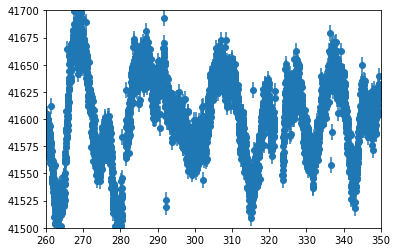

In [15]:
plt.errorbar(lc[1].data['TIME'], lc[1].data['PDCSAP_FLUX'], lc[1].data['PDCSAP_FLUX_ERR'], ls='None', marker='o')
plt.ylim(41500,41700)
plt.xlim(260,350)

(310.0, 320.0)

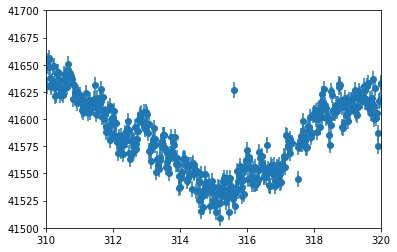

In [16]:
plt.errorbar(lc[1].data['TIME'], lc[1].data['PDCSAP_FLUX'], lc[1].data['PDCSAP_FLUX_ERR'], ls='None', marker='o')
plt.ylim(41500,41700)
plt.xlim(310,320)

no obvious normalisation/constant level for star flux,
some transits very 'thin'

<div class="alert alert-block alert-success">
    
### Your turn: Preparing for fitting:

Locate all transits and make a plot for each

In [17]:
## So far, we have only looked at a subset of the data, the full dataset is stored in the Data folder.
glob.glob('Data/Object%slc/kplr*.fits'%(mykepler)) #Lists all your lightcurve files

['Data/Object1lc/kplr1_17.fits',
 'Data/Object1lc/kplr1_15.fits',
 'Data/Object1lc/kplr1_16.fits',
 'Data/Object1lc/kplr1_14.fits',
 'Data/Object1lc/kplr1_13.fits',
 'Data/Object1lc/kplr1_12.fits',
 'Data/Object1lc/kplr1_11.fits',
 'Data/Object1lc/kplr1_10.fits',
 'Data/Object1lc/kplr1_9.fits',
 'Data/Object1lc/kplr1_8.fits',
 'Data/Object1lc/kplr1_7.fits',
 'Data/Object1lc/kplr1_6.fits',
 'Data/Object1lc/kplr1_5.fits',
 'Data/Object1lc/kplr1_4.fits',
 'Data/Object1lc/kplr1_3.fits',
 'Data/Object1lc/kplr1_2.fits',
 'Data/Object1lc/kplr1_1.fits']

<div class="alert alert-block alert-success">

### Your turn: plot the full lightcurve

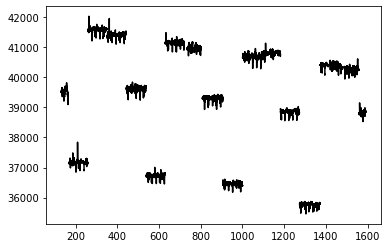

In [18]:
#THis works....
for lcfile in glob.glob('Data/Object%slc/kplr*.fits' %(mykepler)):
    tmp = fits.open(lcfile)
    tmptime = (tmp[1].data['TIME'])
    tmpflux = (tmp[1].data['PDCSAP_FLUX'])
    tmperror = (tmp[1].data['PDCSAP_FLUX_ERR'])
    plt.plot(tmptime, tmpflux, c='k')

<div class="alert alert-block alert-success">

### Your turn: Planning for modelling - Make a plan

- Make a plan for modelling your lightcurve
- Which steps will you need to take? In what order? What tools will you need?
- It might be good to combine all your data into a single file.

In [19]:
from scipy.signal import savgol_filter

lc1_flux = lc[1].data['PDCSAP_FLUX'][~np.isnan(lc[1].data['PDCSAP_FLUX'])]
interp_savgol = savgol_filter( lc1_flux, window_length=201,polyorder=3)
print (len( lc1_flux))
#windowlength is the length of the window over which the polynomial will be fit, polyorder is the order of the polynimial to be fit

4134


In [20]:
time1= lc[1].data['TIME'][~np.isnan(lc[1].data['PDCSAP_FLUX'])] #array[array of true false]- return array true values OR np.isfinite[array] true if number
print(len(time1)) #checking same length
error1 = lc[1].data['PDCSAP_FLUX_ERR'][~np.isnan(lc[1].data['PDCSAP_FLUX'])]

4134


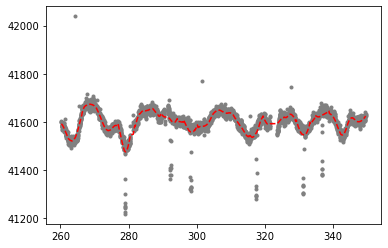

In [21]:
plt.plot(time1, lc1_flux, ls='None', marker='.', c='grey', label='Data')
plt.plot(time1, interp_savgol, ls='--', c='r', label='Savitzky Golay w=11,o=3')

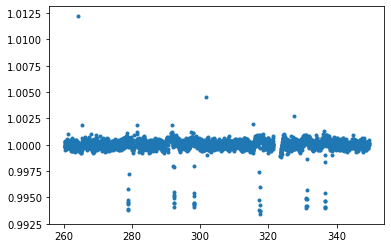

In [22]:
plt.plot(time1, lc1_flux/interp_savgol, ls ='none', marker = 'o', markersize =3)

(0.9925, 1.0025)

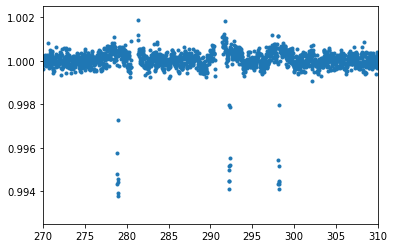

In [23]:
plt.plot(time1, lc1_flux/interp_savgol, ls ='none', marker = 'o', markersize =3)
plt.xlim(270,310)
plt.ylim(0.9925,1.0025)

(0.9925, 1.0)

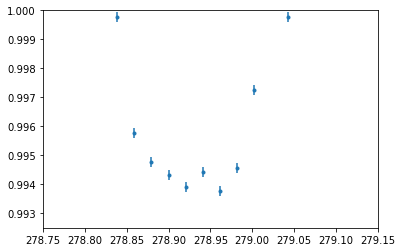

In [24]:
plt.errorbar(time1, lc1_flux/interp_savgol, yerr= error1/interp_savgol, ls ='none', marker = 'o', markersize =3)
plt.xlim(278.75,279.15)
plt.ylim(0.9925,1.000)

In [25]:
def strip_nan(flux, time, err):
    
    """
    function to get rid of all nan values and corresponding values for flux, flux error and time
    returns new arrays without nans
    """
    newflux = flux[~np.isnan(flux)]
    newtime = time[~np.isnan(flux)] 
    newerr = err[~np.isnan(flux)]
    
    return newflux, newtime, newerr
                           

In [26]:
#interp_savgol = savgol_filter( flux2, window_length=201,polyorder=3)
#plt.plot(time2, flux2, ls='None', marker='.', c='grey', label='Data')
#plt.plot(time2, interp_savgol, ls='--', c='r', label='Savitzky Golay w=11,o=3')

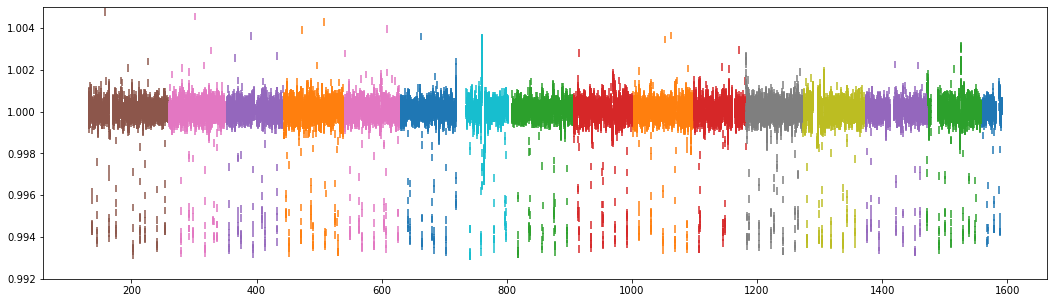

In [27]:
plt.figure(figsize=(18,5))
for lcfile in glob.glob('Data/Object%slc/kplr*.fits' %(mykepler)):
    tmp = fits.open(lcfile)
    flux, time, err = strip_nan(tmp[1].data['PDCSAP_FLUX'],tmp[1].data['TIME'],tmp[1].data['PDCSAP_FLUX_ERR'])
    interp_savgol = savgol_filter( flux, window_length=301,polyorder=3)
    plt.errorbar(time, flux/interp_savgol, yerr = err/interp_savgol, ls ='None')
    plt.ylim(0.992,1.005)

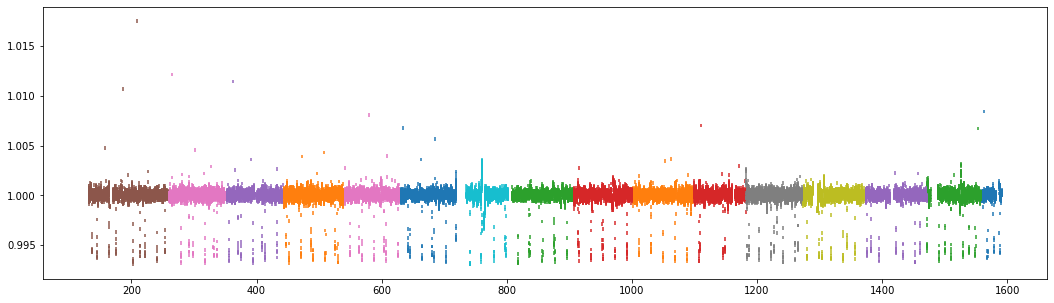

In [28]:
yneg= (flux <0)
normflux=[]
normtime=[]
normerr=[]

plt.figure(figsize=(18,5))
for lcfile in glob.glob('Data/Object%slc/kplr*.fits' %(mykepler)):
    tmp = fits.open(lcfile)
    flux, time, err = strip_nan(tmp[1].data['PDCSAP_FLUX'],tmp[1].data['TIME'],tmp[1].data['PDCSAP_FLUX_ERR'])
    interp_savgol = savgol_filter(flux, window_length=301,polyorder=3)
    normflux.extend(flux/interp_savgol)
    normtime.extend(time)
    normerr.extend(err/interp_savgol)
    plt.errorbar(time, flux/interp_savgol, yerr = err/interp_savgol, ls ='None')
    
    

In [29]:
#writing normalised lightcurve into file
np.savetxt('normalised_curve.txt',np.array([normtime,normflux,normerr]).transpose(), delimiter =',')

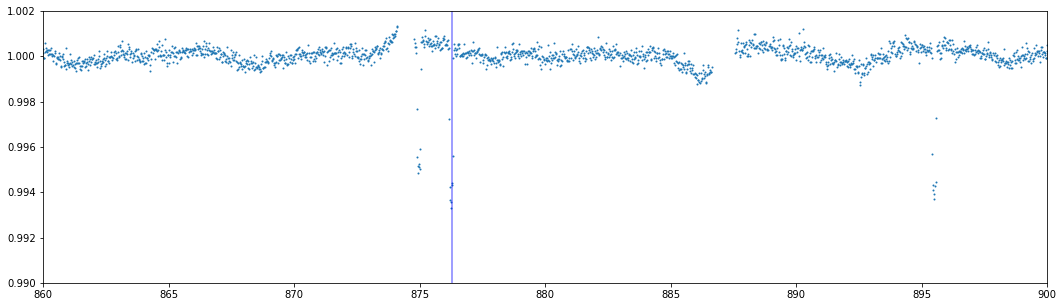

In [143]:
#curve= np.loadtxt('normalised_curve', delimiter=',')
import pandas as pd
curve = pd.read_csv('normalised_curve', delimiter =',', usecols=[0,1,2], names=['time', 'flux', 'error'])
plt.figure(figsize=(18,5))
plt.plot(curve['time'],curve['flux'], ls='None',marker ='o', markersize=1)
plt.xlim(860,900)
plt.ylim(0.99,1.002)
actper = 19.2204 ## the actual period
actper2 =38.938
plt.axvline(actper+131.513013-6.5, c='r') ## indicating the actual period
for i in [1, 2, 3,4,5,6,7,8,9,10,11,12,13,14,15,16,17]:
    plt.axvline((actper*i+131.513013-6.5), c='r')
for i in [1, 2, 3,4,5,6,7,8,9,10,11,20,35,30]:
    plt.axvline((actper2*i+131.513013-34), c='b', alpha=0.5)

In [31]:
#sorted values in ascending time order
curve.sort_values(by=['time'], ascending=True, inplace=True)
print(curve)

              time      flux     error
59035   131.513013  1.000803  0.000181
59036   131.533448  1.000554  0.000181
59037   131.553882  1.000668  0.000181
59038   131.574316  1.000379  0.000181
59039   131.594751  1.000777  0.000181
...            ...       ...       ...
1279   1590.920200  1.000136  0.000182
1280   1590.940635  1.000154  0.000182
1281   1590.961069  1.000504  0.000182
1282   1590.981504  1.000268  0.000182
1283   1591.001938  1.000243  0.000182

[64793 rows x 3 columns]


In [32]:
#checking time sort worked
curve.head()

,time,flux,error
59035,131.513013,1.000803,0.000181
59036,131.533448,1.000554,0.000181
59037,131.553882,1.000668,0.000181
59038,131.574316,1.000379,0.000181
59039,131.594751,1.000777,0.000181


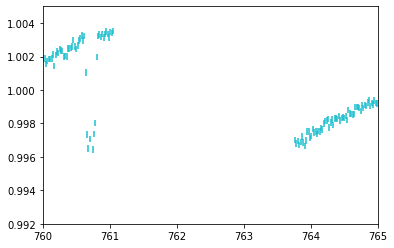

In [33]:

for lcfile in glob.glob('Data/Object%slc/kplr*.fits' %(mykepler)):
    tmp = fits.open(lcfile)
    flux, time, err = strip_nan(tmp[1].data['PDCSAP_FLUX'],tmp[1].data['TIME'],tmp[1].data['PDCSAP_FLUX_ERR'])
    interp_savgol = savgol_filter( flux, window_length=301,polyorder=3)
    plt.errorbar(time, flux/interp_savgol, yerr = err/interp_savgol, ls ='None')
    plt.ylim(0.992,1.005)
    plt.xlim(760,765)
    
    #m = ~((time> 764) & (time < 761 ))
    #tnew = np.arange(761,764,0.01)
    #newfl_sp = interpolate.BSpline(time[m], flux[m], 2, extrapolate=True)
    #plt.plot(tnew, newfl_sp(tnew), ls='--', c='r', label='Spline')

In [34]:
#periodicities
print(curve['time'].iloc[1] - curve['time'].iloc[0])
print(curve['time'].iloc[-1] - curve['time'].iloc[0])

0.020434590805962216
1459.4889253086512


In [35]:
freqs = np.linspace((1/1459.5),(1/0.021), 10000) #1/longest, 1/shortest
import scipy.signal
from scipy.signal import lombscargle
lomb = scipy.signal.lombscargle(curve['time'], curve['flux'], freqs, precenter=True)

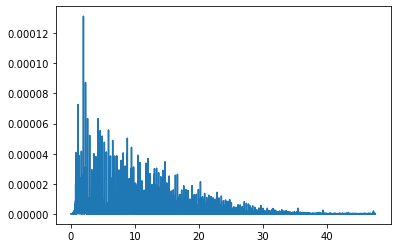

In [36]:
plt.plot(freqs, lomb) #x=freq y=power

In [37]:
period =np.linspace(20,40,10000)
lomb2 = scipy.signal.lombscargle(freqs, lomb, period, precenter=True)

38.463846384638465

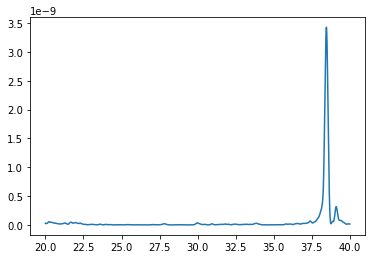

In [38]:
plt.plot(period, lomb2)
period[np.argmax(lomb2)]

In [39]:
def fold_lightcurve(time, flux, error, period):
    """
    Folds the lightcurve given a period.
    time: input time (same unit as period)
    flux: input flux
    error: input error
    period: period to be folded to, needs to same unit as time (i.e. days)
    returns: phase, folded flux, folded error
    """
    #Create a pandats dataframe from the 
    data = pd.DataFrame({'time': time, 'flux': flux, 'error': error})
    
    #create the phase 
    data['phase'] = data.apply(lambda x: ((x.time/ period) - np.floor(x.time / period)), axis=1)
    
    #Creates the out phase, flux and error
    phase_long = np.concatenate((data['phase'], data['phase'] + 1.0, data['phase'] + 2.0))
    flux_long = np.concatenate((flux, flux, flux))
    err_long = np.concatenate((error, error, error))
    
    return(phase_long, flux_long, err_long)

In [40]:
from scipy.signal import medfilt

(0.4, 0.65)

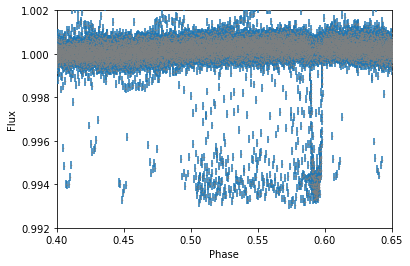

In [41]:
p, p_flux,p_error = fold_lightcurve(curve['time'], curve['flux'], curve['error'], 19.2208)
plt.errorbar(p, p_flux, yerr=p_error, marker='o', markersize=0.5, ls='None', zorder=4, label='_nolegend_', mec='Grey')
plt.xlabel('Phase')
plt.ylabel('Flux')
plt.ylim(0.992,1.002)
plt.xlim(0.4,0.65)

Text(0, 0.5, 'Flux')

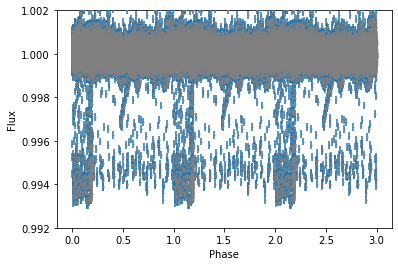

In [47]:
p1, p1_flux,p1_error = fold_lightcurve(curve['time'], curve['flux'], curve['error'], 9.6105)
plt.errorbar(p1, p1_flux, yerr=p1_error, marker='o', markersize=1, ls='None', zorder=4, label='_nolegend_', mec='Grey')
#plt.xlim(1.16,1.2)
plt.ylim(0.992,1.002)
plt.xlabel('Phase')
plt.ylabel('Flux')

Text(0, 0.5, 'Flux')

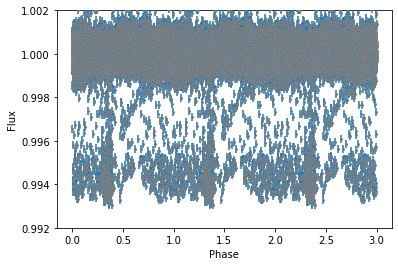

In [43]:
p2, p2_flux,p2_error = fold_lightcurve(curve['time'], curve['flux'], curve['error'], 2.7525)
plt.errorbar(p2, p2_flux, yerr=p2_error, marker='o', markersize=2, ls='None', zorder=4, label='_nolegend_', mec='Grey')
#plt.xlim(1.3,1.5)
plt.ylim(0.992,1.002)
plt.xlabel('Phase')
plt.ylabel('Flux')

Text(0, 0.5, 'Flux')

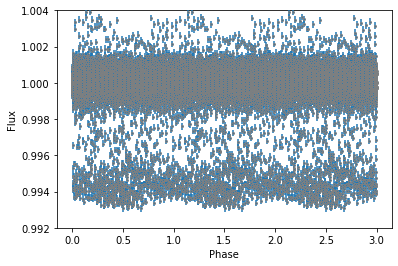

In [44]:
p2, p2_flux,p2_error = fold_lightcurve(curve['time'], curve['flux'], curve['error'], 0.46999) #similar for 0.94, 0.507
plt.errorbar(p2, p2_flux, yerr=p2_error, marker='o', markersize=2, ls='None', zorder=4, label='_nolegend_', mec='Grey')
#plt.xlim(0.24,0.27)
plt.ylim(0.992,1.004)
plt.xlabel('Phase')
plt.ylabel('Flux')

Text(0, 0.5, 'Flux')

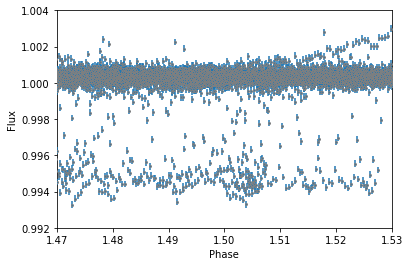

In [138]:
p3, p3_flux,p3_error = fold_lightcurve(curve['time'], curve['flux'], curve['error'], 38.938) 
plt.errorbar(p3, p3_flux, yerr=p3_error, marker='o', markersize=2, ls='None', zorder=4, label='_nolegend_', mec='Grey')
plt.xlim(1.47,1.53)
plt.ylim(0.992,1.004)
plt.xlabel('Phase')
plt.ylabel('Flux')

<a id="sec:summary"></a>
<div class="alert alert-block alert-info">

## Summary:

After completing this notebook, you should have:

- identified and inspected some individual transits
- made a plan for modelling your data